## การสร้างเรขาคณิตแบบจุด (Point Geometry)

หอไอเฟลเป็นหอคอยโครงเหล็กที่สร้างขึ้นในศตวรรษที่ 19 และถือเป็นหนึ่งในสัญลักษณ์ที่โดดเด่นที่สุดของกรุงปารีส  

ตำแหน่งของหอไอเฟลมีพิกัดดังนี้:
- ค่า x = 255422.6  
- ค่า y = 6250868.9

In [1]:
# Import the Point geometry
from shapely.geometry import Point

# Construct a point object for the Eiffel Tower
eiffel_tower = Point(255422.6,6250868.9)

# Print the result
print(eiffel_tower)

POINT (255422.6 6250868.9)


## เมธอดเชิงพื้นที่ของ Shapely

เมื่อเรามีวัตถุ `Point` ของหอไอเฟลที่สร้างด้วย Shapely แล้ว  
เราสามารถใช้เมธอดต่าง ๆ ที่มีอยู่ในวัตถุเรขาคณิตนี้ เพื่อทำการคำนวณและวิเคราะห์เชิงพื้นที่ได้ เช่น

- การคำนวณระยะทาง (distance)
- การตรวจสอบความสัมพันธ์เชิงพื้นที่ (spatial relationship) ระหว่างวัตถุ

In [2]:
import geopandas as gpd
from shapely.geometry import Point

districts = gpd.read_file("../../data/raw/paris_districts_utm.geojson")
district_montparnasse = districts.loc[52, "geometry"]

restaurants = gpd.read_file("../../data/processed/paris_restaurants.geojson")
resto = restaurants.loc[956, "geometry"]


print(eiffel_tower.within(district_montparnasse))
print(district_montparnasse.contains(resto))
print(eiffel_tower.distance(resto))

False
False
6256036.3579150075


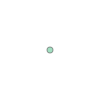

In [5]:
resto

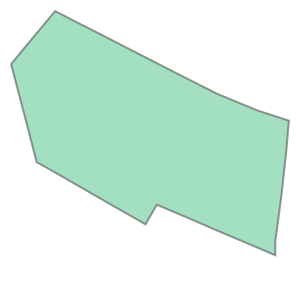

In [3]:
district_montparnasse

## หอไอเฟลตั้งอยู่ในเขตใดของปารีส?

กลับมาที่ตัวอย่างหอไอเฟลอีกครั้ง  
ในแบบฝึกหัดก่อนหน้า เราได้สร้างเรขาคณิตแบบจุด (Point) สำหรับตำแหน่งของหอไอเฟล และตรวจสอบแล้วว่ามันไม่ได้อยู่ในเขต Montparnasse

ตอนนี้ เราจะมาหาว่าหอไอเฟลตั้งอยู่ในเขต (district) ใดของกรุงปารีส

In [ ]:
# อ่านข้อมูลเขต
districts = gpd.read_file("../../data/raw/paris_districts_utm.geojson")

# พิกัดนี้เป็น Web Mercator (EPSG:3857)
eiffel = gpd.GeoSeries([Point(255422.6, 6250868.9)], crs="EPSG:3857")

# แปลงให้ตรงกับ CRS ของ districts (เช่น EPSG:32631)
eiffel = eiffel.to_crs(districts.crs)

mask = districts.contains(eiffel.geometry.squeeze())
print(districts.loc[mask, ["id", "district_name", "population"]])

    id district_name  population
27  28  Gros-Caillou       25156


In [7]:
eiffel.geometry

0    POINT (448252.02 5411954.909)
dtype: geometry

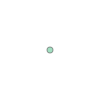

In [8]:
eiffel.geometry.squeeze()

## ร้านอาหารที่ใกล้ที่สุดอยู่ห่างเท่าไร?

ตอนนี้ เราอาจสนใจว่ามีร้านอาหารใดอยู่ใกล้หอไอเฟลบ้าง  
เพื่อสำรวจเรื่องนี้ เราจะทำการแสดงผลตำแหน่งของหอไอเฟล พร้อมทั้งร้านอาหารที่อยู่ในระยะไม่เกิน 1 กิโลเมตรจากจุดนั้น

Closest restaurant distance: 460.6976028277046


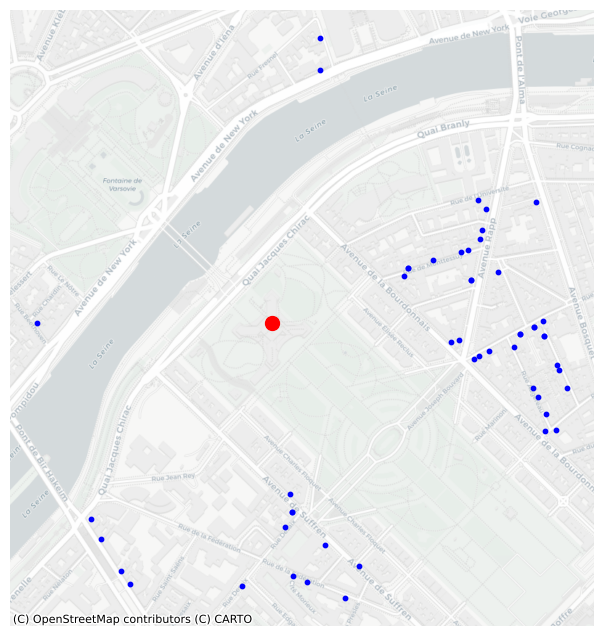

In [12]:
import matplotlib.pyplot as plt
import contextily as ctx
# อ่านข้อมูล
restaurants = gpd.read_file("../../data/processed/paris_restaurants.geojson")

# แก้ป้าย CRS ให้ถูก (ข้อมูลนี้เป็น EPSG:3857)
restaurants = restaurants.to_crs(epsg=3857)

# สร้าง Eiffel Tower ใน 3857
eiffel_tower = gpd.GeoSeries(
    [Point(255422.6, 6250868.9)],
    crs="EPSG:3857"
)

# คำนวณระยะ
dist_eiffel = restaurants.distance(eiffel_tower.iloc[0])

print("Closest restaurant distance:", dist_eiffel.min())

# เลือกร้านในระยะ 1 km
restaurants_eiffel = restaurants[dist_eiffel < 1000]

# Plot
fig, ax = plt.subplots(figsize=(8,8))

restaurants_eiffel.plot(ax=ax, color="blue", markersize=10)
eiffel_tower.plot(ax=ax, color="red", markersize=100)

ctx.add_basemap(ax, crs=restaurants.crs, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.show()

In [17]:
dist_eiffel.median()

np.float64(6025.144529813062)

## ปารีส: การทำ Spatial Join ระหว่างเขตและสถานีจักรยาน

กลับมาที่ข้อมูลกรุงปารีสเกี่ยวกับเขตการปกครอง (districts) และสถานีจักรยานกันอีกครั้ง  

ในขั้นตอนนี้ เราจะใช้การทำ **Spatial Join** เพื่อระบุว่าสถานีจักรยานแต่ละแห่งตั้งอยู่ในเขตใดของปารีส

In [18]:
stations = gpd.read_file("../../data/raw/paris_sharing_bike_stations_utm.geojson")

# Join the districts and stations datasets
joined = stations.sjoin(districts)

# Inspect the first five rows of the result
print(joined.head())

                                          name  bike_stands  available_bikes  \
0                       14002 - RASPAIL QUINET           44                4   
1          20503 - COURS DE VINCENNES PYRÉNÉES           21                3   
2                     20011 - PYRÉNÉES-DAGORNO           21                0   
7                       01007 - ETIENNE MARCEL           16               14   
9  20019 - MAQUIS DU VERCORS - PORTE DES LILAS           30                1   

                         geometry  index_right  id  district_name  population  
0  POINT (450804.449 5409797.268)           52  53   Montparnasse       18570  
1  POINT (456414.352 5410698.461)           79  80       Charonne       62901  
2   POINT (456366.909 5411563.32)           79  80       Charonne       62901  
7  POINT (452159.239 5412494.464)            1   2         Halles        8984  
9   POINT (456635.51 5413988.553)           77  78  Saint-Fargeau       42087  


In [19]:
stations.head()

,name,bike_stands,available_bikes,geometry
0,14002 - RASPAIL QUINET,44,4,POINT (450804.449 5409797.268)
1,20503 - COURS DE VINCENNES PYRÉNÉES,21,3,POINT (456414.352 5410698.461)
2,20011 - PYRÉNÉES-DAGORNO,21,0,POINT (456366.909 5411563.32)
3,31008 - VINCENNES (MONTREUIL),56,0,POINT (458730.707 5411789.995)
4,43006 - MINIMES (VINCENNES),28,27,POINT (458234.93 5409991.067)


In [21]:
districts.head()

,id,district_name,population,geometry
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((451922.133 5411438.484, 451922.08 54..."
1,2,Halles,8984,"POLYGON ((452278.419 5412160.893, 452192.407 5..."
2,3,Palais-Royal,3195,"POLYGON ((451553.806 5412340.522, 451528.058 5..."
3,4,Place-Vendôme,3044,"POLYGON ((451004.908 5412654.095, 450960.64 54..."
4,5,Gaillon,1345,"POLYGON ((451328.752 5412991.278, 451294.721 5..."


In [20]:
joined.head()

,name,bike_stands,available_bikes,geometry,index_right,id,district_name,population
0,14002 - RASPAIL QUINET,44,4,POINT (450804.449 5409797.268),52,53,Montparnasse,18570
1,20503 - COURS DE VINCENNES PYRÉNÉES,21,3,POINT (456414.352 5410698.461),79,80,Charonne,62901
2,20011 - PYRÉNÉES-DAGORNO,21,0,POINT (456366.909 5411563.32),79,80,Charonne,62901
7,01007 - ETIENNE MARCEL,16,14,POINT (452159.239 5412494.464),1,2,Halles,8984
9,20019 - MAQUIS DU VERCORS - PORTE DES LILAS,30,1,POINT (456635.51 5413988.553),77,78,Saint-Fargeau,42087


## แผนที่ความหนาแน่นของต้นไม้รายเขต (1)

โดยใช้ชุดข้อมูลต้นไม้ทั้งหมดในพื้นที่สาธารณะของกรุงปารีส เป้าหมายคือการสร้างแผนที่แสดงความหนาแน่นของต้นไม้ในแต่ละเขต (district)

เพื่อทำเช่นนั้น ขั้นแรกเราจำเป็นต้องทราบว่าในแต่ละเขตมีต้นไม้จำนวนกี่ต้น ซึ่งเราจะดำเนินการในแบบฝึกหัดนี้ จากนั้นในแบบฝึกหัดถัดไป จะนำผลลัพธ์ที่ได้ไปคำนวณความหนาแน่นและสร้างแผนที่ต่อไป

In [23]:
# Read the trees and districts data
trees = gpd.read_file("../../data/raw/paris_trees_small.gpkg")
districts = gpd.read_file("../../data/raw/paris_districts_utm.geojson")

# Spatial join of the trees and districts datasets
joined = gpd.sjoin(trees, districts, predicate="within")

# Calculate the number of trees in each district
trees_by_district = joined.groupby("district_name").size()

# Convert the series to a DataFrame and specify column name
trees_by_district = trees_by_district.to_frame(name='n_trees')

# Inspect the result
print(trees_by_district.head())

                 n_trees
district_name           
Amérique             183
Archives               8
Arsenal               60
Arts-et-Metiers       20
Auteuil              392


In [24]:
trees.head()

,species,location_type,geometry
0,Marronnier,Alignement,POINT (455834.122 5410780.606)
1,Marronnier,Alignement,POINT (446546.284 5412574.697)
2,Marronnier,Alignement,POINT (449768.283 5409876.557)
3,Marronnier,Alignement,POINT (451779.708 5409292.071)
4,Sophora,Alignement,POINT (447041.361 5409756.712)


In [25]:
districts.head()

,id,district_name,population,geometry
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((451922.133 5411438.484, 451922.08 54..."
1,2,Halles,8984,"POLYGON ((452278.419 5412160.893, 452192.407 5..."
2,3,Palais-Royal,3195,"POLYGON ((451553.806 5412340.522, 451528.058 5..."
3,4,Place-Vendôme,3044,"POLYGON ((451004.908 5412654.095, 450960.64 54..."
4,5,Gaillon,1345,"POLYGON ((451328.752 5412991.278, 451294.721 5..."


In [26]:
joined.head()

,species,location_type,geometry,index_right,id,district_name,population
0,Marronnier,Alignement,POINT (455834.122 5410780.606),43,44,Sainte-Marguerite,36476
1,Marronnier,Alignement,POINT (446546.284 5412574.697),62,63,Porte-Dauphine,27423
2,Marronnier,Alignement,POINT (449768.283 5409876.557),57,58,Necker,46932
3,Marronnier,Alignement,POINT (451779.708 5409292.071),51,52,Croulebarbe,19526
4,Sophora,Alignement,POINT (447041.361 5409756.712),59,60,Javel 15Art,49092


In [27]:
trees_by_district.head()

,n_trees
district_name,
Amérique,183
Archives,8
Arsenal,60
Arts-et-Metiers,20
Auteuil,392


## แผนที่ความหนาแน่นของต้นไม้รายเขต (2)

เมื่อเราได้จำนวนต้นไม้ในแต่ละเขตแล้ว ขั้นตอนถัดไปคือการสร้างแผนที่ที่แสดงสีของแต่ละเขตตามความหนาแน่นของต้นไม้

ก่อนอื่น เราต้องนำข้อมูลจำนวนต้นไม้ในแต่ละเขตที่คำนวณไว้ในขั้นตอนก่อนหน้า (`trees_by_district`) มารวม (merge) เข้ากับชุดข้อมูลเขต (`districts`)

โดยจะใช้ฟังก์ชัน `pd.merge()` เพื่อเชื่อมข้อมูลจากสอง DataFrame เข้าด้วยกัน โดยอาศัยคอลัมน์ที่มีค่าเหมือนกันเป็นตัวเชื่อม (common column)

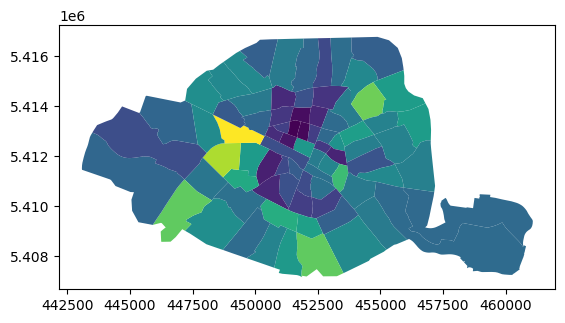

In [28]:
import pandas as pd
# Merge the 'districts' and 'trees_by_district' dataframes
districts_trees = pd.merge(districts, trees_by_district, on='district_name')

# Add a column with the tree density
districts_trees['n_trees_per_area'] = districts_trees['n_trees'] / districts_trees.geometry.area

# Make of map of the districts colored by 'n_trees_per_area'
districts_trees.plot(column="n_trees_per_area")
plt.show()

## แผนที่ Choropleth แบบช่วงเท่ากัน (Equal Interval)

ในแบบฝึกหัดก่อนหน้า เราได้สร้างแผนที่แสดงความหนาแน่นของต้นไม้ไปแล้ว ตอนนี้เมื่อเราเข้าใจเรื่อง choropleth มากขึ้น เราจะมาสำรวจการแสดงผลแบบนี้ให้ลึกขึ้น

ขั้นแรก เราจะเปรียบเทียบผลลัพธ์ระหว่างการใช้ “จำนวนต้นไม้ทั้งหมด” กับการใช้ “จำนวนต้นไม้ที่ปรับตามพื้นที่ของเขต” (ความหนาแน่นของต้นไม้)

ขั้นต่อมา เราจะสร้างแผนที่แบบ **Equal Interval** แทนการใช้สเกลสีแบบต่อเนื่อง โดยวิธีการจัดกลุ่มนี้จะแบ่งช่วงค่าของข้อมูลออกเป็นช่วงที่มีความกว้างเท่ากัน และกำหนดสีให้แต่ละช่วง

   id           district_name  population  \
0   1  St-Germain-l'Auxerrois        1672   
1   2                  Halles        8984   
2   3            Palais-Royal        3195   
3   4           Place-Vendôme        3044   
4   5                 Gaillon        1345   

                                            geometry  n_trees  \
0  POLYGON ((451922.133 5411438.484, 451922.08 54...       40   
1  POLYGON ((452278.419 5412160.893, 452192.407 5...       40   
2  POLYGON ((451553.806 5412340.522, 451528.058 5...        4   
3  POLYGON ((451004.908 5412654.095, 450960.64 54...        7   
4  POLYGON ((451328.752 5412991.278, 451294.721 5...        7   

   n_trees_per_area  
0          0.000046  
1          0.000097  
2          0.000015  
3          0.000026  
4          0.000037  


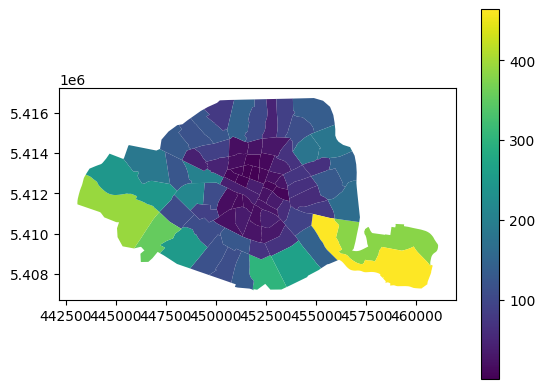

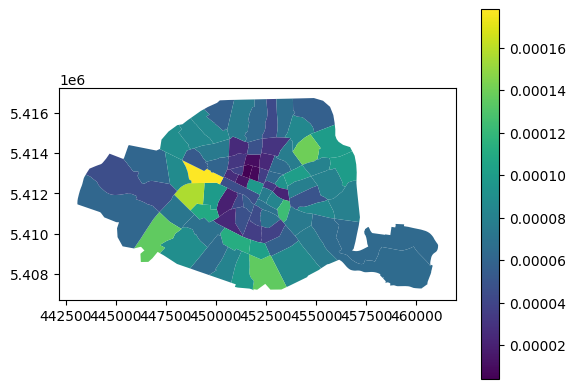

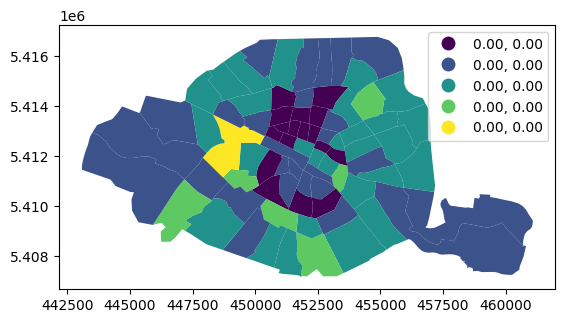

In [ ]:
# Print the first rows of the tree density dataset
print(districts_trees.head())

# Make a choropleth of the number of trees 
districts_trees.plot(column="n_trees", legend=True)
plt.show()

# Make a choropleth of the number of trees per area
districts_trees.plot(column="n_trees_per_area", legend=True)
plt.show()

# Make a choropleth of the number of trees 
districts_trees.plot(column="n_trees_per_area", scheme="equal_interval", legend=True)
plt.show()

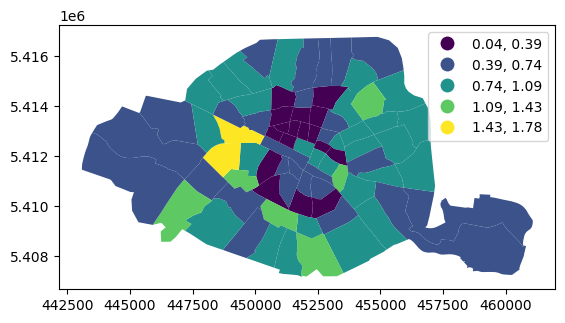

In [30]:
districts_trees['n_trees_per_areax10000'] = districts_trees['n_trees_per_area'] * 10000
districts_trees.plot(column="n_trees_per_areax10000", scheme="equal_interval", legend=True)
plt.show()

In [31]:
districts_trees.crs

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## แผนที่ Choropleth แบบ Quantiles

ในแบบฝึกหัดนี้ เราจะสร้างแผนที่ความหนาแน่นของต้นไม้แบบ **Quantile**

อัลกอริทึมแบบ Quantile จะจัดเรียงค่าข้อมูลและแบ่งออกเป็นกลุ่มที่มีจำนวนข้อมูลเท่ากัน เพื่อกำหนดสีให้แต่ละกลุ่ม

ครั้งนี้ เราจะสร้างทั้งหมด **7 กลุ่ม** และใช้ชุดสี **YlGn colormap** กระจายครอบคลุมช่วงค่าทั้งหมดของข้อมูล

มีตัวแปร `n_trees_per_area` สำหรับวัดความหนาแน่นของต้นไม้ในแต่ละเขต  
(หมายเหตุ: ค่าตัวแปรนี้ถูกคูณด้วย 10,000)

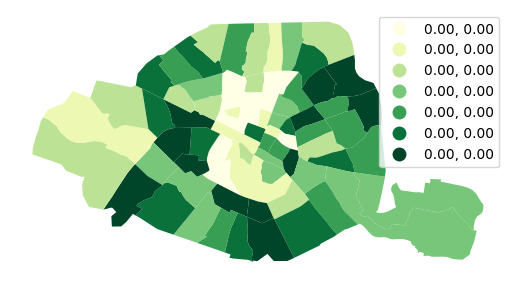

In [32]:
# Generate the choropleth and store the axis
ax = districts_trees.plot(column='n_trees_per_area', scheme='quantiles',
                          k=7, cmap='YlGn', legend=True)

# Remove frames, ticks and tick labels from the axis
ax.set_axis_off()
plt.show()

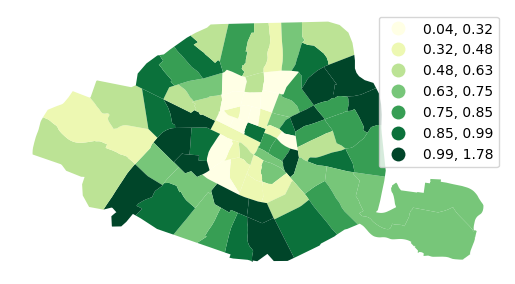

In [33]:
# Generate the choropleth and store the axis
ax = districts_trees.plot(column='n_trees_per_areax10000', scheme='quantiles',
                          k=7, cmap='YlGn', legend=True)

# Remove frames, ticks and tick labels from the axis
ax.set_axis_off()
plt.show()

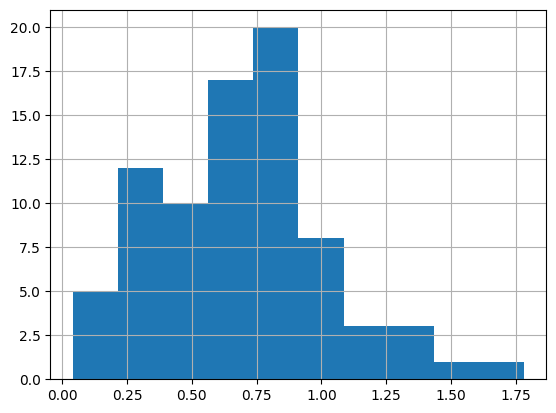

In [34]:
districts_trees['n_trees_per_areax10000'].hist()
plt.show()

## เปรียบเทียบอัลกอริทึมการจัดกลุ่มข้อมูล (Classification Algorithms)

ในแบบฝึกหัดสุดท้ายนี้ คุณจะสร้างแผนที่หลายรูป (multi-map figure)  
เพื่อเปรียบเทียบสองแนวทางในการแสดงตัวแปรบนแผนที่ที่เราได้เรียนรู้มา

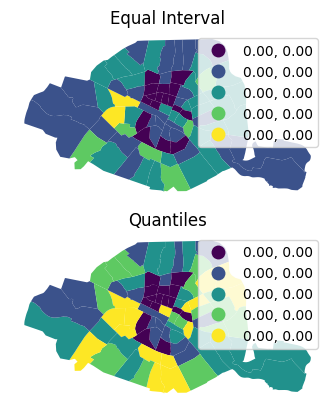

In [35]:
# Set up figure and subplots
fig, axes = plt.subplots(nrows=2)

# Plot equal interval map
districts_trees.plot(column="n_trees_per_area", scheme="equal_interval", k=5, legend=True, ax=axes[0])
axes[0].set_title('Equal Interval')
axes[0].set_axis_off()

# Plot quantiles map
districts_trees.plot(column="n_trees_per_area", scheme="quantiles", k=5, legend=True, ax=axes[1])
axes[1].set_title('Quantiles')
axes[1].set_axis_off()

# Display maps
plt.show()

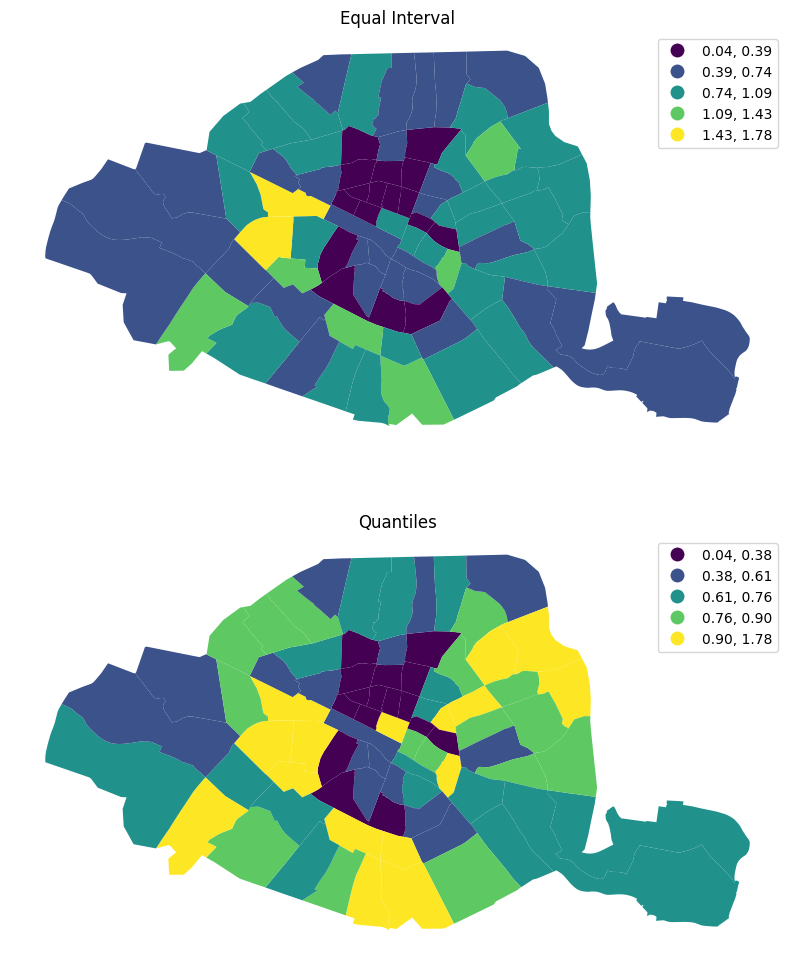

In [37]:
# Set up figure and subplots
fig, axes = plt.subplots(nrows=2, figsize=(10, 12))

# Plot equal interval map
districts_trees.plot(column="n_trees_per_areax10000", scheme="equal_interval", k=5, legend=True, ax=axes[0])
axes[0].set_title('Equal Interval')
axes[0].set_axis_off()

# Plot quantiles map
districts_trees.plot(column="n_trees_per_areax10000", scheme="quantiles", k=5, legend=True, ax=axes[1])
axes[1].set_title('Quantiles')
axes[1].set_axis_off()

# Display maps
plt.show()